In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import gc

# Loading and preprocessing

In [2]:
#data_path = "datasets/GSE124395_Normalhumanlivercellatlasdata.txt"
#df = pd.read_csv(data_path, sep="\t")

In [3]:
#df = df.astype("int32")
#df = df.T
#df.to_csv("datasets/GSE124395_Normalhumanlivercellatlasdata.transposed.txt", sep="\t")

In [4]:
adata = sc.read_csv("datasets/GSE124395_Normalhumanlivercellatlasdata.transposed.txt", delimiter="\t")

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

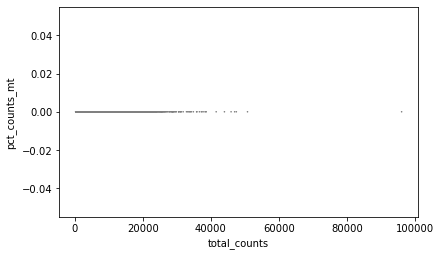

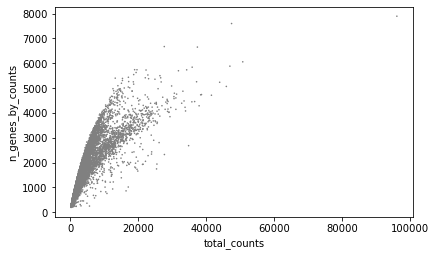

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [7]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata.raw = adata
adata.shape

(12024, 23151)

# Normalizting and scaling

In [8]:
# normalization and scaling
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)
sc.pp.scale(adata, max_value=10)

# UMAP and clustering

In [9]:
# PCA and UMAP
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

In [10]:
# Perform clustering
sc.tl.leiden(adata, resolution=0.5)

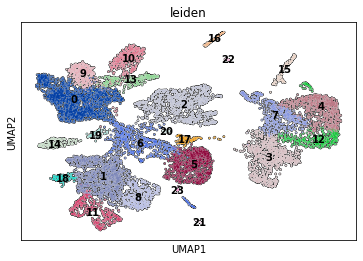

In [11]:
# Plot stuff
sc.pl.umap(adata, color=['leiden'], legend_loc="on data",  add_outline=True)

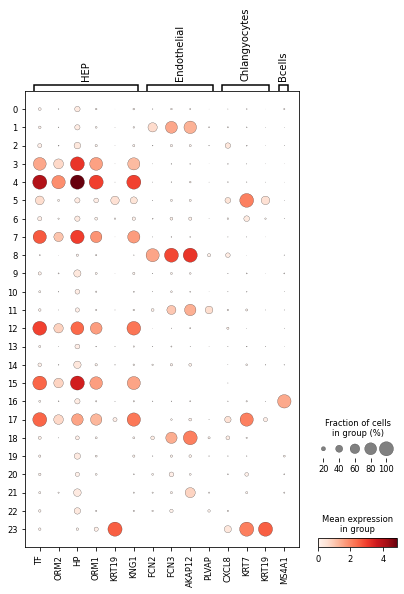

In [12]:
markers = {'HEP': ['TF', 'ORM2', 'HP', 'ORM1', 'KRT19', 'KNG1'],
          'Endothelial': ['FCN2', 'FCN3', 'AKAP12', 'PLVAP'],
          'Chlangyocytes': ['CXCL8', 'KRT7', 'KRT19'],
          'Bcells': ['MS4A1']}
sc.pl.dotplot(adata, markers, groupby='leiden', log=True)

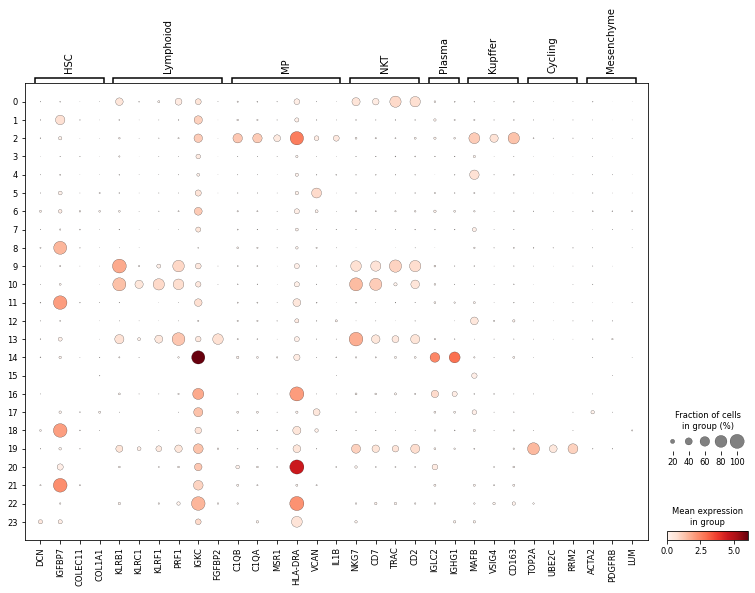

In [13]:
markers = {'HSC': ['DCN', 'IGFBP7', 'COLEC11', 'COL1A1'],
          'Lymphoiod': ['KLRB1', 'KLRC1', 'KLRF1', 'PRF1', 'IGKC', 'FGFBP2'],
          'MP': ['C1QB', 'C1QA', 'MSR1', 'HLA-DRA', 'VCAN', 'IL1B'],
          'NKT': ['NKG7', 'CD7','TRAC', 'CD2'],
          'Plasma': ['IGLC2', 'IGHG1'],
          'Kupffer': ['MAFB', 'VSIG4', 'CD163'],
          'Cycling': ['TOP2A', 'UBE2C', 'RRM2'],
          'Mesenchyme': ['ACTA2', 'PDGFRB', 'LUM']}
sc.pl.dotplot(adata, markers, groupby='leiden', log=True)

In [14]:
old_to_new = {
    '0':"NKT",
    '1':"Endothelial",
    '2':"MP",
    '3':"Hepatocytes",
    '4':"Hepatocytes",
    '5':"Chlangyocytes",
    '6':"Unknown",
    '7':"Hepatocytes",
    '8':"Endothelial",
    '9':"NKT",
    '10':"NKT",
    '11':"Endothelial",
    '12':"Hepatocytes",
    '13':"NKT",
    '14':"Plasma",
    '15':"Hepatocytes",
    '16':"Bcells",
    '17':"Hepatocytes",
    '18':"Endothelial",
    '19':"NKT",
    '20':"MP",
    '21':"HSC",
    '22':"MP",
    '23':"Chlangyocytes"
}
adata.obs['celltype'] = (
    adata.obs['leiden']
    .map(old_to_new)
    .astype('category')
)

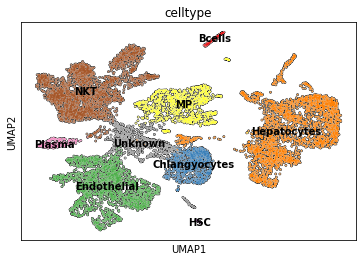

In [15]:
sc.pl.umap(adata, color="celltype", legend_loc="on data", palette="Set1", add_outline=True)

In [16]:
celltypes = adata.obs.celltype
adata = adata.raw.to_adata()

In [17]:
adata = adata[adata.obs.celltype != "Unknown",]
adata.shape

(11366, 23151)

In [18]:
adata.write("GSE124395_labeled.h5ad")